In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf

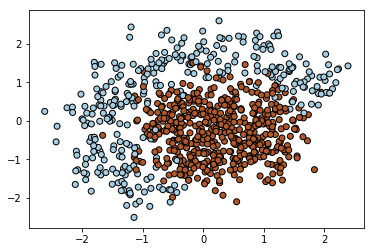

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()

In [3]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):
    plt.clf()
    plt.figure(figsize=(20, 8))
    with tf.Session() as sess:
        Z = sess.run(classify(np.c_[xx.ravel(), yy.ravel()], w))
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())


**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
def expand(X):
    X_ = tf.zeros((tf.shape(X)[0], 6), dtype=tf.float64)
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    X_ = tf.concat([X, X ** 2, X0 * X1, tf.ones(shape=(tf.shape(X)[0], 1), dtype=tf.float64)], axis=1)
    return X_

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    X_ = expand(X)
    dot_product = tf.matmul(X_, tf.reshape(w, [-1, 1]))
    ones = tf.ones(shape=[tf.shape(X)[0], 1], dtype=tf.float64)
    return tf.where(tf.greater(dot_product, 0), ones, -ones)

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [5]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    X_ = expand(X)
    shape = (tf.shape(X)[0], 1)
    zeros = tf.zeros(shape=shape, dtype=tf.float64)
    ones = tf.ones(shape=shape, dtype=tf.float64)
    dot_product = tf.multiply(y, tf.matmul(X_, tf.reshape(w, [-1, 1])))
    maxim = tf.reduce_max(tf.concat([zeros, ones -  dot_product], axis=1), axis=1)#tf.maximum(zeros, ones - tf.multiply(y, dot_product))
    return tf.reduce_mean(maxim)
    
    
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X_ = expand(X)
    shape = (tf.shape(X)[0], 6)
    zeros = tf.zeros(shape=shape, dtype=tf.float64)
    ones = tf.ones(shape=shape, dtype=tf.float64)
    mult = tf.multiply(y, X_)
    condition = tf.less(ones - tf.multiply(w, mult), zeros)
    return tf.reduce_mean(tf.where(condition, zeros, - mult), axis=0)

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

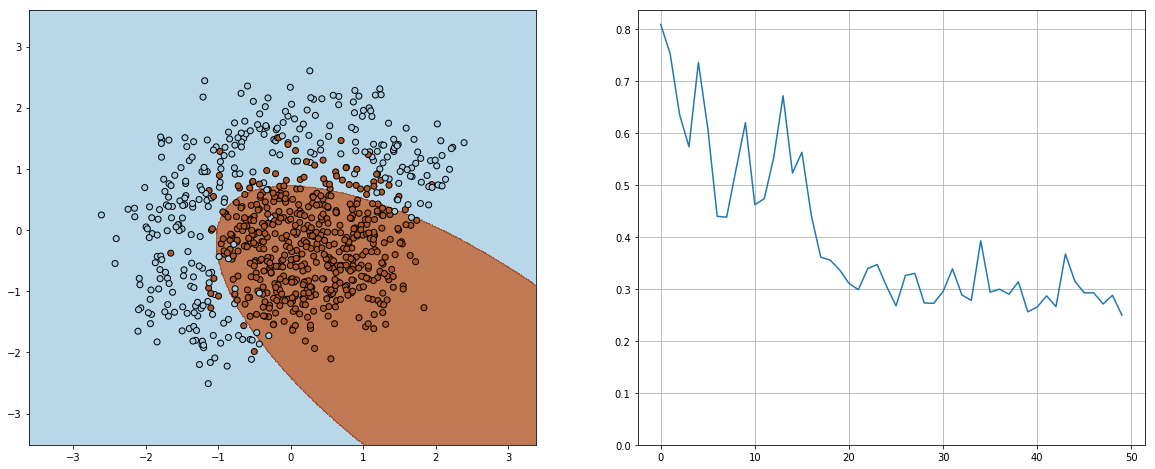

In [14]:
w = np.array([1,0,0,0,0,0], dtype=np.float64)
W = tf.Variable(w, dtype=tf.float64, name='weights')

X_holder = tf.placeholder(tf.float64, shape=(None, 2), name='X')
Y_holder = tf.placeholder(tf.float64, shape=(None,1), name='Y')

alpha = 0.3 # learning rate

loss_ = compute_loss(X_holder, Y_holder, W)
update_W_ = tf.assign(W, W - alpha * compute_grad(X_holder, Y_holder, W))

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        print(i)
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind, :]
        Y_batch = y[ind].reshape((batch_size, 1))
        loss[i] = sess.run(loss_, feed_dict={X_holder:X, Y_holder:y.reshape((-1, 1))})
        
        #visualize(X[ind,:], y[ind], w, loss, n_iter)

        w = sess.run(update_W_, feed_dict={X_holder:X_batch, Y_holder:Y_batch})

visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

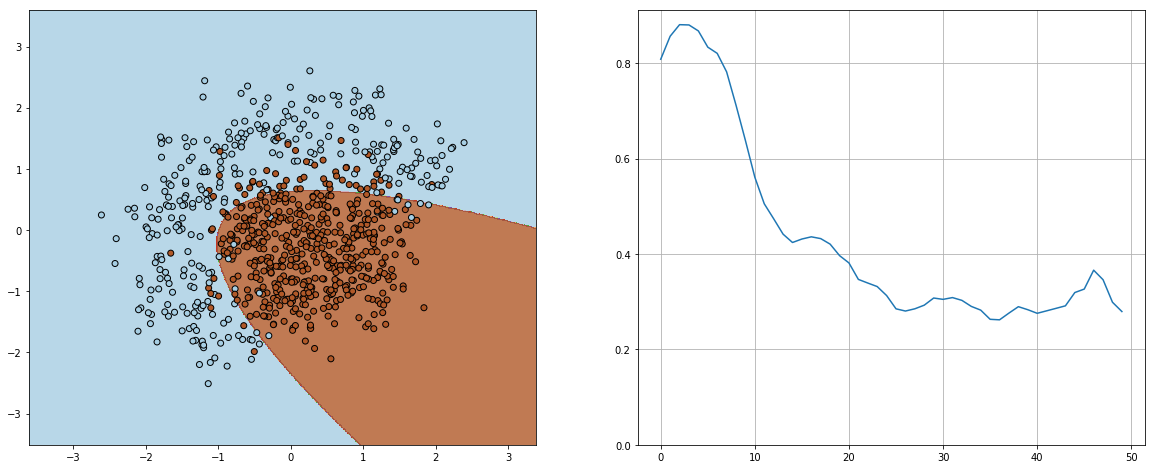

In [15]:
w = np.array([1,0,0,0,0,0], dtype=np.float64)
v = np.array([0,0,0,0,0,0], dtype=np.float64)

alpha = 0.1 # learning rate
mu    = 0.5 # momentum

W = tf.Variable(w, dtype=tf.float64, name='weights')
V = tf.Variable(w, dtype=tf.float64, name='V')

update_V = tf.assign(V, mu * V - alpha * compute_grad(X_holder, Y_holder, W))
update_W = tf.assign(W, W + update_V)

loss_ = compute_loss(X_holder, Y_holder, W)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind, :]
        Y_batch = y[ind].reshape((batch_size, 1))
        loss[i] = sess.run(loss_, feed_dict={X_holder:X, Y_holder:y.reshape((-1, 1))})
        #visualize(X[ind,:], y[ind], w, loss, n_iter)

        w = sess.run(update_W, feed_dict={X_holder:X_batch, Y_holder:Y_batch})

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

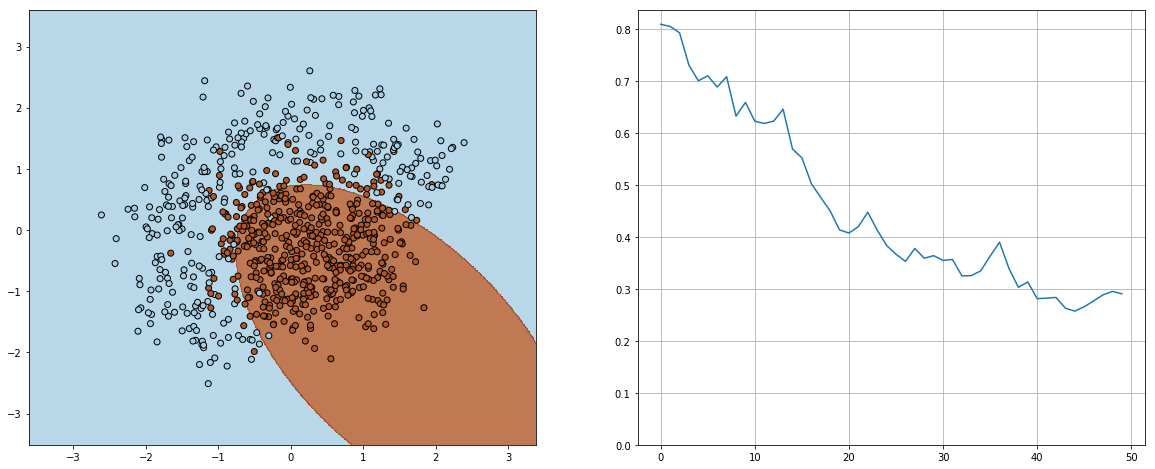

In [18]:
w = np.array([1,0,0,0,0,0], dtype=np.float64)
v = np.array([0,0,0,0,0,0], dtype=np.float64)

alpha = 0.1 # learning rate
mu    = 0.1 # momentum

W = tf.Variable(w, dtype=tf.float64, name='weights')
V = tf.Variable(v, dtype=tf.float64, name='V')

update_W_momentum = tf.assign(W, W - mu * V)
update_V = tf.assign(V, mu * V - alpha * compute_grad(X_holder, Y_holder, W))
update_W_total = tf.assign(W, W - alpha * compute_grad(X_holder, Y_holder, W))

loss_ = compute_loss(X_holder, Y_holder, W)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind, :]
        Y_batch = y[ind].reshape((batch_size, 1))
        loss[i] = sess.run(loss_, feed_dict={X_holder:X, Y_holder:y.reshape((-1, 1))})
        #visualize(X[ind,:], y[ind], w, loss, n_iter)

        w = sess.run(update_W_momentum, feed_dict={X_holder:X_batch, Y_holder:Y_batch})
        v = sess.run(update_V, feed_dict={X_holder:X_batch, Y_holder:Y_batch})
        w = sess.run(update_W_total, feed_dict={X_holder:X_batch, Y_holder:Y_batch})

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaGrad:

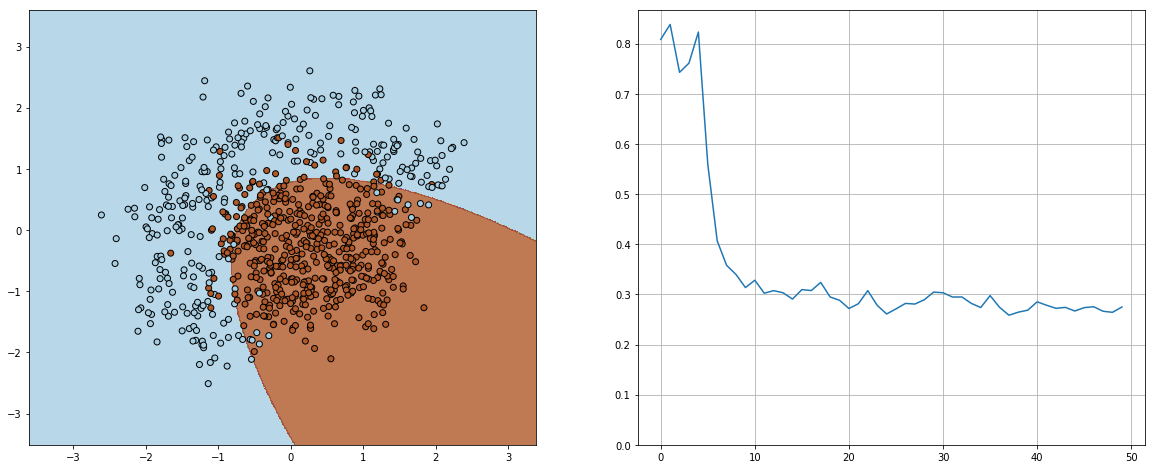

In [23]:
w = np.array([1,0,0,0,0,0], dtype=np.float64)

alpha = 0.3# learning rate
mu    = 0 # momentum
eps = 1e-8  # A small constant for numerical stability

c = np.array([0,0,0,0,0,0], dtype=np.float64)
W = tf.Variable(w, dtype=tf.float64, name='weights')
C = tf.Variable(c, dtype=tf.float64, name='C')

grad = compute_grad(X_holder, Y_holder, W)
update_C = tf.assign(C, C + tf.square(grad))
update_W = tf.assign(W, W - alpha / (tf.sqrt(update_C) + eps) * grad)

loss_ = compute_loss(X_holder, Y_holder, W)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind, :]
        Y_batch = y[ind].reshape((batch_size, 1))
        loss[i] = sess.run(loss_, feed_dict={X_holder:X, Y_holder:y.reshape((-1, 1))})
        #visualize(X[ind,:], y[ind], w, loss, n_iter)

        w = sess.run(update_W, feed_dict={X_holder:X_batch, Y_holder:Y_batch})

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaDelta:

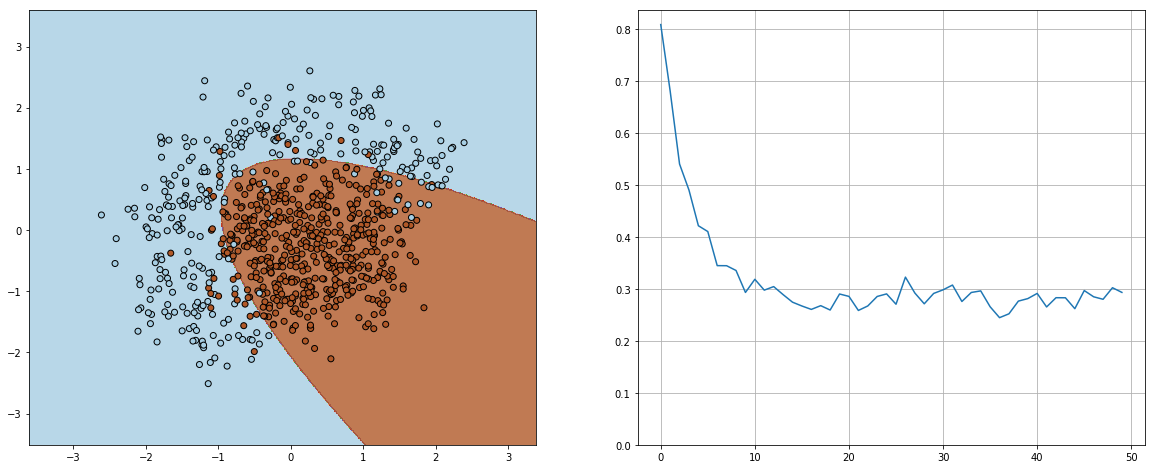

In [29]:
w = np.array([1,0,0,0,0,0], dtype=np.float64)

alpha = 0.1# learning rate
mu    = 0.7 # momentum
eps = 1e-8  # A small constant for numerical stability

c = np.array([0,0,0,0,0,0], dtype=np.float64)
W = tf.Variable(w, dtype=tf.float64, name='weights')
C = tf.Variable(c, dtype=tf.float64, name='C')

grad = compute_grad(X_holder, Y_holder, W)
update_C = tf.assign(C, mu * C + (1 - mu) * tf.square(grad))
update_W = tf.assign(W, W - alpha / (tf.sqrt(update_C) + eps) * grad)

loss_ = compute_loss(X_holder, Y_holder, W)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind, :]
        Y_batch = y[ind].reshape((batch_size, 1))
        loss[i] = sess.run(loss_, feed_dict={X_holder:X, Y_holder:y.reshape((-1, 1))})
        #visualize(X[ind,:], y[ind], w, loss, n_iter)

        w = sess.run(update_W, feed_dict={X_holder:X_batch, Y_holder:Y_batch})

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

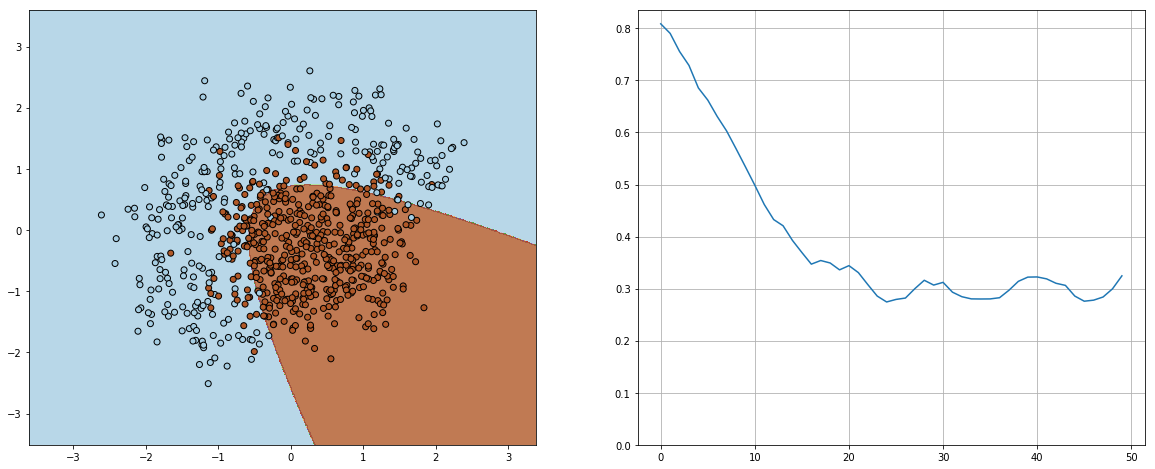

In [34]:
w = np.array([1,0,0,0,0,0], dtype=np.float64)

alpha = 0.1 # learning rate
beta = 0.7  # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu   = 0.6  # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps = 1e-8  # A small constant for numerical stability

v = np.array([0,0,0,0,0,0], dtype=np.float64)
c = np.array([0,0,0,0,0,0], dtype=np.float64)
W = tf.Variable(w, dtype=tf.float64, name='weights')
V = tf.Variable(v, dtype=tf.float64, name='V')
C = tf.Variable(c, dtype=tf.float64, name='C')

grad = compute_grad(X_holder, Y_holder, W)
update_V = tf.assign(V, beta * V + (1 - beta) * grad)
update_C = tf.assign(C, mu * C + (1 - mu) * tf.square(grad))
update_W = tf.assign(W, W - alpha / (tf.sqrt(update_C) + eps) * update_V)

loss_ = compute_loss(X_holder, Y_holder, W)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind, :]
        Y_batch = y[ind].reshape((batch_size, 1))
        loss[i] = sess.run(loss_, feed_dict={X_holder:X, Y_holder:y.reshape((-1, 1))})
        #visualize(X[ind,:], y[ind], w, loss, n_iter)

        w = sess.run(update_W, feed_dict={X_holder:X_batch, Y_holder:Y_batch})

visualize(X, y, w, loss, n_iter)
plt.clf()